In [1]:
import itertools
import pickle
import math

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic("load_ext autoreload")
get_ipython().magic("autoreload 2")

In [3]:
with open('./tree_model.pkl', 'rb') as opened:
    tree_model = pickle.load(opened)

In [4]:
tree_model

DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=100)

In [5]:
tree = tree_model.tree_

In [6]:
import tree_shap

In [7]:
tree.predict(np.array([[150, 75, 200]], dtype=np.float32))

array([[20.]])

In [8]:
x = [150, 75, 200]

In [9]:
assert tree_shap.exp_value(x, S={}, tree=tree) == 23
assert tree_shap.exp_value(x, S={0}, tree=tree) == 20
assert tree_shap.exp_value(x, S={1}, tree=tree) == 27
assert tree_shap.exp_value(x, S={0, 1}, tree=tree) == 20

In [53]:
x2 = np.array([100, 25, 400])

In [62]:
shap.TreeExplainer?

In [55]:
explainer = shap.TreeExplainer(tree_model)
explainer.shap_values(x2)

array([20.,  7.,  0.])

In [56]:
x = x2

In [57]:
# ϕ0 = tree_shap.exp_value(x, {}, tree)

# ϕs = []
preds = {}
for card in range(0, len(x) + 1):
    for perm in itertools.permutations(range(len(x)), r=card):
        preds[tuple(perm)] = tree_shap.exp_value(x, S=set(perm), tree=tree)

In [58]:
preds

{(): 23.0,
 (0,): 40.0,
 (1,): 27.0,
 (2,): 23.0,
 (0, 1): 50.0,
 (0, 2): 40.0,
 (1, 0): 50.0,
 (1, 2): 27.0,
 (2, 0): 40.0,
 (2, 1): 27.0,
 (0, 1, 2): 50.0,
 (0, 2, 1): 50.0,
 (1, 0, 2): 50.0,
 (1, 2, 0): 50.0,
 (2, 0, 1): 50.0,
 (2, 1, 0): 50.0}

In [59]:
deltas = [0] * len(x)
for perm in itertools.permutations(range(len(x)), r=len(x)):
    for index, i in enumerate(perm):
        deltas[i] += preds[perm[:index+1]] - preds[perm[:index]]

In [60]:
np.array(deltas) / math.factorial(len(x))

array([20.,  7.,  0.])

In [40]:
ϕ0 = preds[()]
ϕs = []
for i in range(len(x)):
    delta = 0
    for key in preds:
        if i in key:
            delta += preds[key] - preds[tuple(_ for _ in key if _ != i)]
#     ϕs.append(delta / math.factorial(len(x)))
    ϕs.append(delta)

In [41]:
ϕ0

23.0

In [42]:
ϕs

[-65.0, 12.0, 0.0]

In [11]:
features_tuple = ((0, 150), (1, 75), (2, 200))

In [17]:
# follows the calculation at https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b closely

basis = tree_shap.exp_value(x, {}, tree)

all_phis = []
for perm in itertools.permutations(features_tuple):
    phis = {"basis": basis}
    for i in range(len(perm)):
        phi_raw = tree_shap.exp_value(x, S={_[0] for _ in perm[: i + 1]}, tree=tree)
        phi = phi_raw - sum(phis.values())
        phis[perm[i][0]] = phi
    all_phis.append(phis)

In [18]:
perm

((2, 200), (1, 75), (0, 150))

In [19]:
{_[0] for _ in perm}

{0, 1, 2}

In [20]:
all_phis

[{'basis': 23.0, 0: -3.0, 1: 0.0, 2: 0.0},
 {'basis': 23.0, 0: -3.0, 2: 0.0, 1: 0.0},
 {'basis': 23.0, 1: 4.0, 0: -7.0, 2: 0.0},
 {'basis': 23.0, 1: 4.0, 2: 0.0, 0: -7.0},
 {'basis': 23.0, 2: 0.0, 0: -3.0, 1: 0.0},
 {'basis': 23.0, 2: 0.0, 1: 4.0, 0: -7.0}]

In [21]:
pd.DataFrame(all_phis)

,basis,0,1,2
0,23.0,-3.0,0.0,0.0
1,23.0,-3.0,0.0,0.0
2,23.0,-7.0,4.0,0.0
3,23.0,-7.0,4.0,0.0
4,23.0,-3.0,0.0,0.0
5,23.0,-7.0,4.0,0.0


In [22]:
pd.DataFrame(all_phis).mean()

basis    23.0
0        -5.0
1         2.0
2         0.0
dtype: float64

In [33]:
math.factorial(3)

6

In [41]:
preds = {}

for card in range(len(x) + 1):  # cardinality of S
    for perm in itertools.permutations(range(len(x)), r=card):
        S = set(perm)
        preds[S] = tree_shap.exp_value(x, S, tree)

TypeError: unhashable type: 'set'

In [58]:
pd.DataFrame(all_phis).mean(axis=0)

basis    23.0
0        -1.0
1        -1.0
2        -1.0
dtype: float64

In [ ]:
all_phis = []
for permutation in itertools.permutations(features_tuple):
    phis = {'basis': basis}
    for i in range(len(permutation)):
        phi_raw = tree_shap.naive_tree_shap(tree, current_node=0, features=dict(permutation[:i + 1]))
        phi = phi_raw - sum(phis.values())
        phis[permutation[i][0]] = phi
    all_phis.append(phis)

In [48]:
pd.DataFrame(all_phis).mean(axis=0)

basis    23.0
0        -5.0
1         2.0
2         0.0
dtype: float64

In [25]:
tree_shap.exp_value(x, S={1, 2}, tree=tree)

27.0

In [8]:
tree_shap.naive_tree_shap(
    tree,
    current_node=0,
    features={0: 150},
)

20.0

In [9]:
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={0: 150},
    )
    == 20
)
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={1: 75},
    )
    == 27
)

# given feature 0, having feature 1 doesn't make a difference
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={0: 150, 1: 75},
    )
    == 20
)

In [20]:
X_test = pd.DataFrame(
    {
        "x0": [150],
        "x1": [75],
        "x2": [200],
    }
)

In [68]:
tree.n_node_samples

array([10,  4,  2,  2,  6,  1,  5], dtype=int64)

In [63]:
tree.children_left

array([ 1,  2, -1, -1,  5, -1, -1], dtype=int64)

In [70]:
tree.children_right

array([ 4,  3, -1, -1,  6, -1, -1], dtype=int64)

In [67]:
tree.feature

array([ 0,  1, -2, -2,  0, -2, -2], dtype=int64)

In [72]:
tree.threshold

array([100., 300.,  -2.,  -2., 200.,  -2.,  -2.])

In [21]:
tree_model.predict(X_test)

array([20.])

In [47]:
import sklearn.tree

In [51]:
tree.value?

In [50]:
tree.value.shape

(7, 1, 1)

In [57]:
tree.value

array([[[15.]],

       [[40.]],

       [[50.]],

       [[30.]],

       [[10.]],

       [[20.]],

       [[10.]]])

In [60]:
tree.n_node_samples

array([10,  4,  2,  2,  6,  1,  5], dtype=int64)

In [29]:
tree.n_outputs

1

In [32]:
tree_model.feature_names_in_

array(['x0', 'x1', 'x2'], dtype=object)

In [33]:
tree_model.tree_.feature

array([ 0,  1, -2, -2,  0, -2, -2], dtype=int64)

In [28]:
tree.max_n_classes

1

In [45]:
tree_model.max_features_

3

In [43]:
tree.predict(np.array([[150, 75, 200]], dtype=np.float32))

array([[20.]])

In [14]:
tree.children_left?

In [12]:
tree.feature

array([ 0,  1, -2, -2,  0, -2, -2], dtype=int64)

In [7]:
tree.node_count

7

In [8]:
import tree_shap

In [9]:
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={0: 150},
    )
    == 20
)
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={1: 75},
    )
    == 27
)

# given feature 0, having feature 1 doesn't make a difference
assert (
    tree_shap.naive_tree_shap(
        tree,
        current_node=0,
        features={0: 150, 1: 75},
    )
    == 20
)

In [10]:
import itertools

In [13]:
features_tuple = ((0, 150), (1, 75), (2, 200))

**Need to rename the variables here to make it more readable**

In [44]:
all_phis = []
for permutation in itertools.permutations(features_tuple):
    phis = {'basis': basis}
    for i in range(len(permutation)):
        phi_raw = tree_shap.naive_tree_shap(tree, current_node=0, features=dict(permutation[:i + 1]))
        phi = phi_raw - sum(phis.values())
        phis[permutation[i][0]] = phi
    all_phis.append(phis)

In [45]:
all_phis

[{'basis': 23.0, 0: -3.0, 1: 0.0, 2: 0.0},
 {'basis': 23.0, 0: -3.0, 2: 0.0, 1: 0.0},
 {'basis': 23.0, 1: 4.0, 0: -7.0, 2: 0.0},
 {'basis': 23.0, 1: 4.0, 2: 0.0, 0: -7.0},
 {'basis': 23.0, 2: 0.0, 0: -3.0, 1: 0.0},
 {'basis': 23.0, 2: 0.0, 1: 4.0, 0: -7.0}]

In [48]:
pd.DataFrame(all_phis).mean(axis=0)

basis    23.0
0        -5.0
1         2.0
2         0.0
dtype: float64

In [36]:
from collections import OrderedDict

In [43]:
OrderedDict(features_tuple)[:2]

TypeError: unhashable type: 'slice'

In [38]:
list(itertools.permutations(OrderedDict(features_tuple)))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [35]:
permutation

((2, 200), (1, 75), (0, 150))

In [27]:
phis

[23.0, 0.0, 4.0, -7.0]

In [28]:
permutation

((2, 200), (1, 75), (0, 150))

In [34]:
np.array(all_phis)[:, 1:]

array([[-3.,  0.,  0.],
       [-3.,  0.,  0.],
       [ 4., -7.,  0.],
       [ 4.,  0., -7.],
       [ 0., -3.,  0.],
       [ 0.,  4., -7.]])

In [33]:
np.array(all_phis)[:, 1:].mean(axis=0)

array([ 0.33333333, -1.        , -2.33333333])

In [29]:
itertools.subpermutation

(0, 1, 2)

In [10]:
tree.feature

array([ 0,  1, -2, -2,  0, -2, -2])

In [30]:
tree.tree_.value

array([[[15.]],

       [[40.]],

       [[50.]],

       [[30.]],

       [[10.]],

       [[20.]],

       [[10.]]])

In [46]:
tree.decision_path([[150, 75, 200]]).todense()

matrix([[1, 0, 0, 0, 1, 1, 0]])

In [17]:
tree.tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1])

In [18]:
tree.tree_.children_right

array([ 4,  3, -1, -1,  6, -1, -1])

In [23]:
tree.tree_.

4

In [24]:
tree.tree_.threshold

array([100., 300.,  -2.,  -2., 200.,  -2.,  -2.])

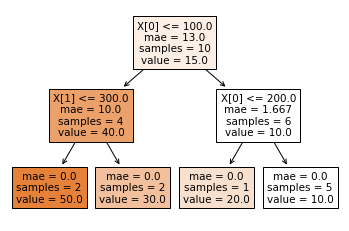

In [22]:
_ = plot_tree(tree, filled=True, proportion=False)

Explain for the example [x=150, y=75, z=200]

In [26]:
import sklearn

In [41]:
tree.tree_.threshold

array([100., 300.,  -2.,  -2., 200.,  -2.,  -2.])

In [40]:
tree.tree_.feature

array([ 0,  1, -2, -2,  0, -2, -2])

In [39]:
tree.tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1])

In [42]:
tree.tree_.children_right

array([ 4,  3, -1, -1,  6, -1, -1])

In [31]:
tree.tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1])

In [47]:
from collections import OrderedDict

In [56]:
features = [[1, 75], [2, 200], [0, 150]]

In [57]:
features[:2]

[[1, 75], [2, 200]]

In [58]:
tree.tree_.n_node_samples

array([10,  4,  2,  2,  6,  1,  5])

In [ ]:
def decision_path(i):
    """
    i: index of features
    """
    if i == tree.tree_.feature[0]

x > y > z

In [12]:
phi_x = 20 - phi_null

In [13]:
phi_y = 20 - phi_x - phi_null

In [14]:
phi_z = 20 - phi_y - phi_x - phi_null

In [15]:
phi_z

0.0

y > z > x

In [16]:
phi_y = (4 / 10) * 50 + (6 / 10) * (1 / 6 * 20 + 5 / 6 * 10) - phi_null

In [17]:
phi_y

4.0

In [18]:
phi_z = 0

In [19]:
phi_x = 20 - phi_y - phi_null

In [20]:
phi_x

-7.0

In [21]:
tree.predict([[150, 75, 200]])

array([20.])

In [22]:
X_test = pd.DataFrame({'x': [150], 'y': [75], 'z': [200]})

In [24]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_test)
shap_values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


array([[-5.,  2.,  0.]])